Imports and Setup

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
import keras_tuner as kt
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from skimage import io, transform
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Unique Identifier Extraction To Match Images with Respective Masks

In [2]:
def extract_id(filename):
    """
    Extracts the unique identifier from the filename.
    Assumes the identifier is between 'cxrimage_' and '.png' or 'cxrmask_' and '.jpeg'.
    """
    if 'cxrimage_' in filename:
        return filename.split('cxrimage_')[1].split('.png')[0]
    elif 'cxrmask_' in filename:
        return filename.split('cxrmask_')[1].split('.jpeg')[0]
    return None

Data Loading and Preprocessing

In [3]:
# Data Preprocessing
def load_and_preprocess_image(image_path, mask_path, target_size=(128, 128)):
    """
    Load and preprocess a single image and its corresponding mask.
    """
    try:
        # Load the image and mask
        image = io.imread(image_path, as_gray=True)
        mask = io.imread(mask_path, as_gray=True)
        
        # Resize to target size
        image = transform.resize(image, target_size, mode='constant', preserve_range=True)
        mask = transform.resize(mask, target_size, mode='constant', preserve_range=True)
        
        # Normalize images
        image = image / 255.0
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)  # Ensure the mask has a single channel
        
        return image, mask
    except Exception as e:
        print(f"Error loading images {image_path} and {mask_path}: {e}")
        return None, None

In [4]:
# Load data
def load_data_from_directories(image_dir, mask_dir, target_size=(128, 128)):
    """
    Load and preprocess images and masks from given directories.
    Pairs images with masks based on their unique identifier.
    """
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    mask_filenames = [f for f in os.listdir(mask_dir) if f.endswith('.jpeg')]
    
    # Create a dictionary to map identifiers to mask filenames
    mask_dict = {}
    for mask_filename in mask_filenames:
        mask_id = extract_id(mask_filename)
        if mask_id:
            mask_dict[mask_id] = os.path.join(mask_dir, mask_filename)
    
    images = []
    masks = []
    
    print("Loading data...")
    
    # Iterate over image files and find corresponding masks
    for img_filename in image_filenames:
        image_id = extract_id(img_filename)
        if image_id:
            image_path = os.path.join(image_dir, img_filename)
            mask_path = mask_dict.get(image_id)  # Get corresponding mask path
            
            if mask_path:
                # Load and preprocess the image and mask
                image, mask = load_and_preprocess_image(image_path, mask_path, target_size)
                if image is not None and mask is not None:
                    images.append(image)
                    masks.append(mask)
                else:
                    print(f"Skipping {image_path} and {mask_path} due to loading error.")
            else:
                print(f"No corresponding mask found for {image_path}.")
    
    print(f"Loaded {len(images)} images and masks.")
    return np.array(images), np.array(masks)

Metrics

In [5]:
# This the dice coefficient function definition
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
# This is the Intersection over Union function definition
def iou(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [7]:
# This the sensitivity function definition
def sensitivity(y_true, y_pred):
    true_positive = tf.keras.backend.sum(y_true * y_pred)
    possible_positive = tf.keras.backend.sum(y_true)
    return true_positive / (possible_positive + tf.keras.backend.epsilon())

Model Definition with Tunable Hyperparameters

In [8]:
# Define the U-Net Model
def unet_model(hp):
    """
    Build a U-Net model with hyperparameters for tuning.
    """
    
    # Retrieve hyperparameters with default values
    filters1 = hp.values.get('filters1', 64)
    filters2 = hp.values.get('filters2', 128)
    filters3 = hp.values.get('filters3', 256)
    filters4 = hp.values.get('filters4', 512)
    filters5 = hp.values.get('filters5', 256)
    filters6 = hp.values.get('filters6', 128)
    filters7 = hp.values.get('filters7', 64)
    learning_rate = hp.values.get('learning_rate', 1e-4)
    
    inputs = Input(shape=(128, 128, 1))
    
    # Encoder
    conv1 = Conv2D(filters1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(filters1, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(filters2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(filters2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(filters3, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(filters3, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(filters4, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(filters4, (3, 3), activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(filters5, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(filters5, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(filters6, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(filters6, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(filters7, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(filters7, (3, 3), activation='relu', padding='same')(conv7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), dice_coefficient, iou, sensitivity]
    )
    
    return model

Function That Keras Tuner Uses To Build And Configure A Model With Different Hyperparameter Values

In [9]:
# Hyperparameter Tuning
def build_model(hp):
    """
    Build the U-Net model for hyperparameter tuning.
    """
    return unet_model(hp)


Hyperparameter Tuning

In [10]:
# This is to define a function for hyperparameters tuning
def tune_hyperparameters(X_train, y_train, X_val, y_val):
    """
    Perform hyperparameter tuning using Keras Tuner.
    """
    tuner = Hyperband(
        hypermodel=unet_model,
        objective='val_loss',
        max_epochs=20,
        factor=3,
        directory='my_dir',
        project_name='helloworld'
    )
    
    tuner.search(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps

Various Plots' Function Definition

In [11]:
# This is to plot traing and validation's accuracy and loss
def plot_history(history):
    """
    Plot training and validation accuracy, loss, and custom metrics curves.
    """
    plt.figure(figsize=(16, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(2, 3, 1)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Plot Dice coefficient
    plt.subplot(2, 3, 3)
    if 'dice_coefficient' in history.history:
        plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
    if 'val_dice_coefficient' in history.history:
        plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend(loc='upper right')
    
    # Plot IoU
    plt.subplot(2, 3, 4)
    if 'iou' in history.history:
        plt.plot(history.history['iou'], label='Train IoU')
    if 'val_iou' in history.history:
        plt.plot(history.history['val_iou'], label='Validation IoU')
    plt.title('IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend(loc='upper right')
    
    # Plot Sensitivity
    plt.subplot(2, 3, 5)
    if 'sensitivity' in history.history:
        plt.plot(history.history['sensitivity'], label='Train Sensitivity')
    if 'val_sensitivity' in history.history:
        plt.plot(history.history['val_sensitivity'], label='Validation Sensitivity')
    plt.title('Sensitivity')
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return "Plots generated successfully"

Predictions, Results & Other Visualizations Display

In [12]:
# This is predictions results display function
def display_results(X_val, y_val, model):
    """
    Display a sample image, its mask, and the predicted mask from the validation set.
    """
    # Predict on validation set
    predictions = model.predict(X_val)
    
    # Display the first sample
    sample_idx = 0
    sample_image = X_val[sample_idx]
    sample_mask = y_val[sample_idx]
    sample_pred = predictions[sample_idx]
    
    # Plot image, mask, and prediction
    plt.figure(figsize=(12, 4))
    
    # Display the image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image.squeeze(), cmap='gray')
    
    # Display the mask
    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    
    # Display the prediction
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(sample_pred.squeeze(), cmap='gray')
    
    plt.show()

Main Definition

In [13]:
# This is the main program
def main():
    # Load and preprocess data

    # Set directories for images and masks
    image_dir = 'Resources/Images Data'
    mask_dir = 'Resources/Masks Data'

    # Load and preprocess data
    X, y = load_data_from_directories(image_dir, mask_dir)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning
    best_hps = tune_hyperparameters(X_train, y_train, X_val, y_val)
    
    # Build and train the model with best hyperparameters
    model = unet_model(best_hps)
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    
    # Retrieve hyperparameters
    epochs = best_hps.values.get('epochs', 200)
    batch_size = best_hps.values.get('batch_size', 128)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Evaluate the model
    results = model.evaluate(X_val, y_val)
    loss, accuracy, dice_coefficient, iou, sensitivity = results
    print(f"Loss: {results[0]}")
    print(f"Accuracy: {results[1]}")
    print(f"Dice Coefficient: {results[2]}")
    print(f"Intersection over Union (IoU): {results[3]}")
    print(f"Sensitivity: {results[4]}")
    
    # Plot training history
    plot_history(history)
    #display(plot_history)
    
    # Display sample results
    display_results(X_val, y_val, model)

Main Calling

Loading data...
Loaded 500 images and masks.
Reloading Tuner from my_dir\helloworld\tuner0.json
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 10s/step - binary_accuracy: 0.3740 - dice_coefficient: 0.0016 - iou: 7.9883e-04 - loss: 0.6235 - sensitivity: 0.4018 - val_binary_accuracy: 0.6368 - val_dice_coefficient: 0.0020 - val_iou: 0.0010 - val_loss: 0.5071 - val_sensitivity: 0.3937 - learning_rate: 0.0051
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - binary_accuracy: 0.6487 - dice_coefficient: 0.0013 - iou: 6.3967e-04 - loss: 0.2989 - sensitivity: 0.2045 - val_binary_accuracy: 0.6368 - val_dice_coefficient: 6.9851e-10 - val_iou: 6.4521e-10 - val_loss: 0.0946 - val_sensitivity: 5.4024e-11 - learning_rate: 0.0051
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - binary_accuracy: 0.6509 - dice_coefficient: 2.3450e-04 - iou: 1.1729e-04 - loss: 0.0500 - sensitivity: 9.6829e-04 - val_binary_accuracy: 0.6368 - val_dice_coefficient: 6.0513e-05 - val_iou: 3.0258e-05 - val_loss: 0.0121 - val_se

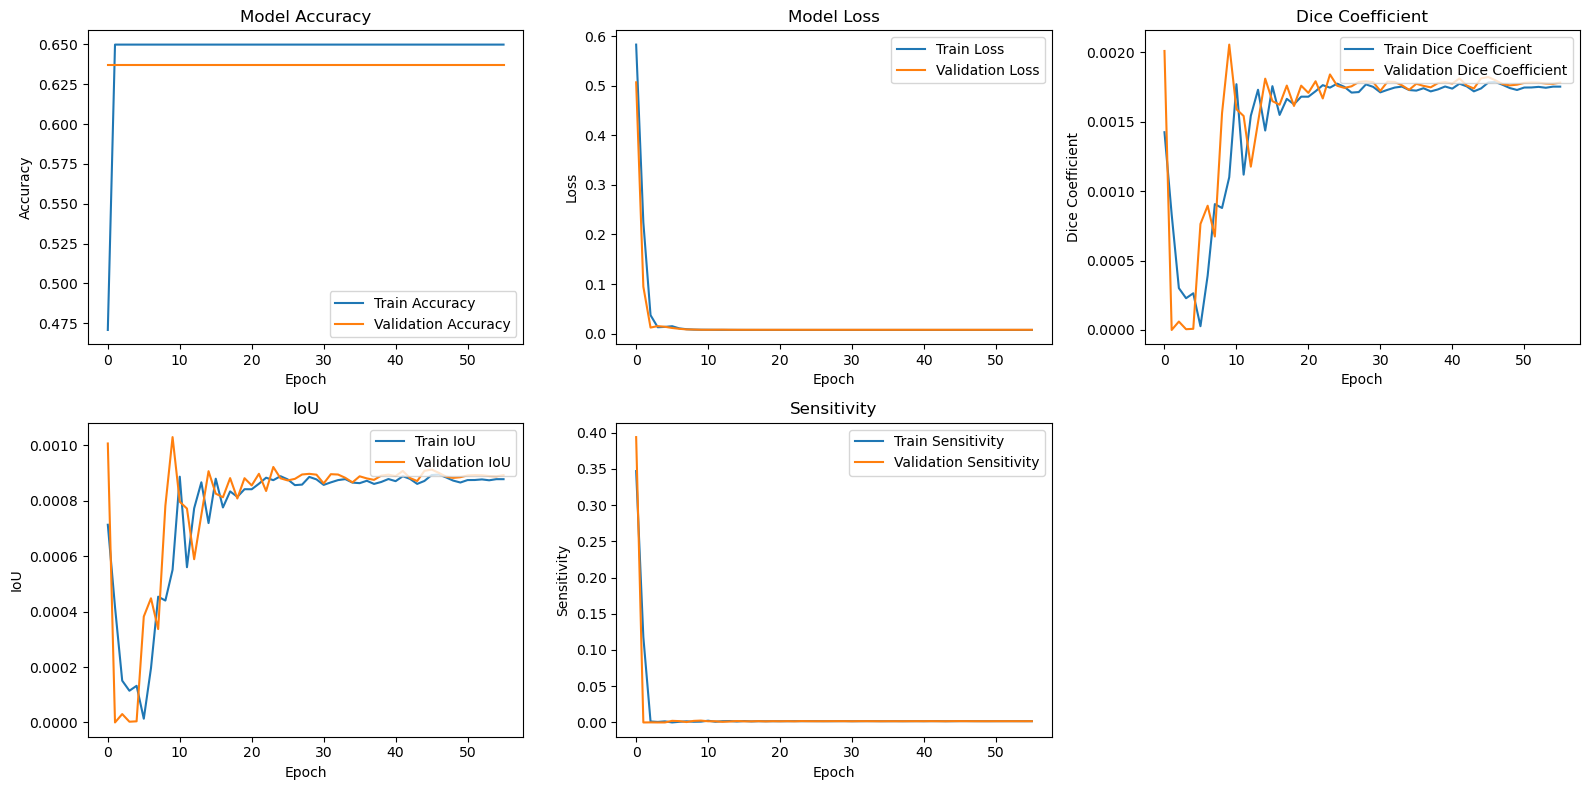

<function __main__.plot_history(history)>

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step


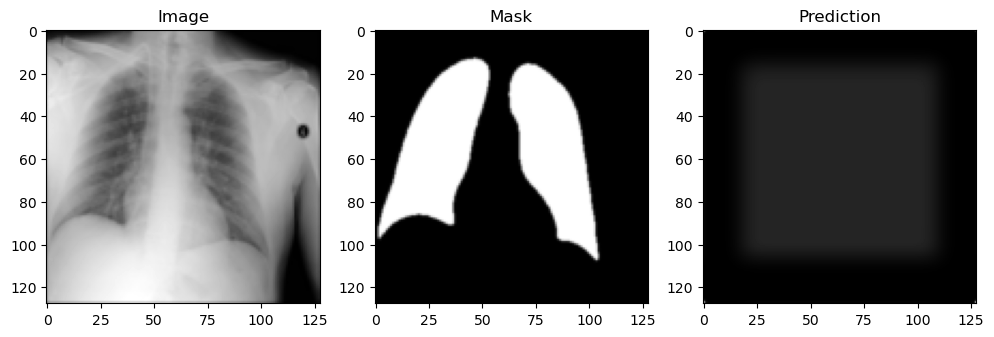

In [14]:
if __name__ == '__main__':
    main()